In [3]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
import math


import scipy 

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic, PyCutestGetter, Ackley
from RBF import RBF

from scipy.interpolate import Rbf, RBFInterpolator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

class Dixon:
    # Boundary x = [-2, 2] , y= [-1, 1]
    
    def __init__(self, sig=0,  noise_type="gaussian"):
        self.sig = sig
        self.noise_type = noise_type
        self._f1 = grad(lambda x: self.f(x, None))
        self._f2 = jacfwd(lambda x: self.f1(x))

    def f(self, X, jrandom_key=None):
        
        x, y = X
        
        # transform 
        x = x*jnp.abs(jnp.sin(jnp.pi*x/2.))
        y = jnp.sign(y)*jnp.abs(y)/2.
                   
        out = (4 - 2.1 * x**2  + 1/3 * x**4)*x**2 + x*y + (-4 + 4*y**2)*y**2

        if jrandom_key is not None:
            if self.noise_type == "uniform":
                eps = self.sig * jnp.sqrt(3)
                return out + 2 * eps * jrandom.uniform(jrandom_key) - eps
            else:
                return out + self.sig * jrandom.normal(jrandom_key) 
        return out 

    def f1(self, X):
        return self._f1(X)
    
    def f2(self, X):
        return self._f2(X).reshape(X.size, X.size)

In [4]:
# func_name = "DENSCHNF"
# sig = 1
# func_name, x_0, F = PyCutestGetter(func_name=func_name, dim_i=0, sig=sig, noise_type="gaussian")

sig = 0.01
dim = 2
F = Dixon(sig)


jrandom_key = jrandom.PRNGKey(0)


In [5]:
x_lim = [-2, 2]
y_lim = [-2, 2]

num_x = 100
num_y = 100

x = jnp.linspace(x_lim[0], x_lim[1], num_x)
y = jnp.linspace(y_lim[0], y_lim[1], num_y)

X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()])

Z = np.array([F.f(p) for p in positions.T]).reshape(num_y, num_x)

num_x_f1 = 20
num_y_f1 = 20

xf1 = jnp.linspace(x_lim[0], x_lim[1], num_x_f1)
yf1 = jnp.linspace(y_lim[0], y_lim[1], num_y_f1)

Xf1, Yf1 = np.meshgrid(xf1, yf1)
positionsf1 = np.vstack([Xf1.ravel(), Yf1.ravel()])

Zf1 = np.array([F.f1(p) for p in positionsf1.T]).reshape(num_y_f1, num_x_f1, 2)

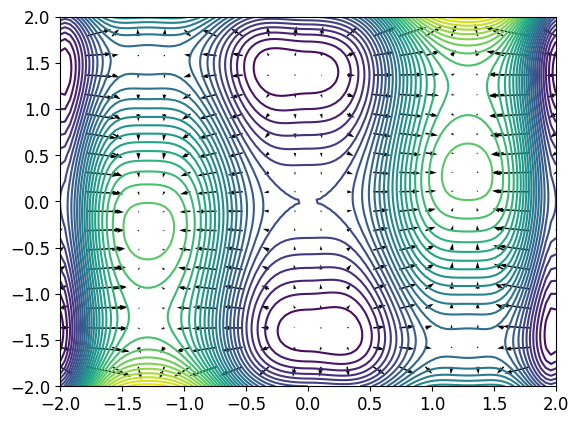

In [6]:
plt.contour(X, Y, Z, levels=30)
plt.rcParams['figure.figsize'] = [5, 5]



plt.quiver(Xf1, Yf1, Zf1[:, :, 0], Zf1[:, :, 1], angles="xy")

In [7]:
rbf_x_lim = [x_lim[0] - 0.1, x_lim[1] + 0.1]
rbf_y_lim = [y_lim[0] - 0.2, y_lim[1] + 0.2]

num_x_rbf = 15
num_y_rbf = 15

xrbf = jnp.linspace(rbf_x_lim[0], rbf_x_lim[1], num_x_rbf)
yrbf = jnp.linspace(rbf_y_lim[0], rbf_y_lim[1], num_y_rbf)

Xrbf, Yrbf = np.meshgrid(xrbf, yrbf)
positions_rbf = np.vstack([Xrbf.ravel(), Yrbf.ravel()])

rbf_F_vals = []
for i in range(positions_rbf.shape[1]):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    subkey = None
    rbf_F_vals.append(F.f(positions_rbf[:, i], subkey))

rbf_F_vals = jnp.array(rbf_F_vals)
    
rbf = RBF(positions_rbf, rbf_F_vals, smoothing=0)

In [8]:
Z_rbf = np.array([rbf.f(p) for p in positions.T]).reshape(num_y, num_x)

Z_rbf1 = np.array([rbf.f1(p) for p in positionsf1.T]).reshape(num_y_f1, num_x_f1, 2)

total err 28.13755843530989


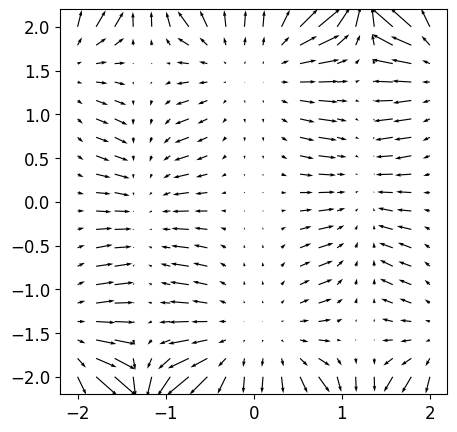

In [9]:



# plt.contour(X, Y, Z_rbf, levels=10)
# plt.quiver(Xf1, Yf1, Zf1[:, :, 0], Zf1[:, :, 1], color="blue")
plt.quiver(Xf1, Yf1, Z_rbf1[:, :, 0], Z_rbf1[:, :, 1])


print("total err", jnp.linalg.norm(Z_rbf1 - Zf1))




In [10]:
# H_getter = lambda x: F.f2(x)
H_getter = lambda x: rbf.f2(x)

res = {"ours": {}, "FD": {}, "CFD": {}}

hs = [0.075, 0.1, 0.125]
m = 0
for h in hs:

    grad_getter_ours = Ours(sig, max_h=h)
    grad_getter_fd = FD(sig, is_central=False, h=h, use_H=True)
    grad_getter_cfd = FD(sig, is_central=True, h=h, use_H=False)

    jrandom_key = jrandom.PRNGKey(0)

    res["ours"][h] = []
    res["FD"][h] = []
    res["CFD"][h] = []

    for x_0 in tqdm(positionsf1.T):
        jrandom_key, subkey = jrandom.split(jrandom_key)
        H = H_getter(x_0)
        
        m = max(jnp.abs(jnp.linalg.cond(H)), m)
    
        res["ours"][h].append(grad_getter_ours.grad(F, x_0, subkey, H=H)[0])
        res["FD"][h].append(grad_getter_fd.grad(F, x_0, subkey, H=H)[0])
        res["CFD"][h].append(grad_getter_cfd.grad(F, x_0, subkey, H=None)[0])

100%|█████████████████████████████████████████| 400/400 [00:12<00:00, 31.12it/s]


In [11]:
m

DeviceArray(100.74690891, dtype=float64)

total err 27.378651661284696


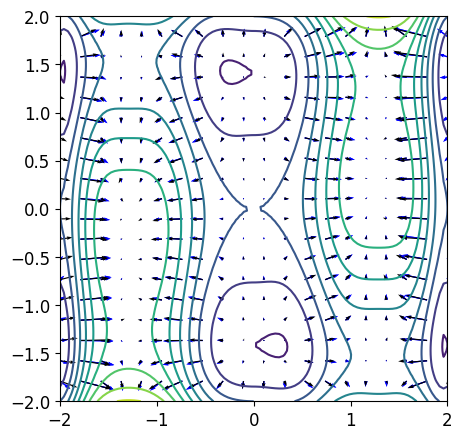

(array([356.,   8.,   9.,  17.,   1.,   3.,   1.,   1.,   3.,   1.]),
 array([0.00963539, 0.92647296, 1.84331054, 2.76014811, 3.67698569,
        4.59382326, 5.51066083, 6.42749841, 7.34433598, 8.26117356,
        9.17801113]),
 <BarContainer object of 10 artists>)

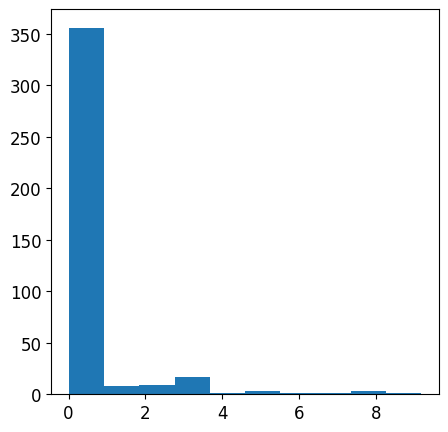

In [12]:
plt.contour(X, Y, Z, levels=10)
plt.quiver(Xf1, Yf1, Zf1[:, :, 0], Zf1[:, :, 1], color="blue")

curr_Z_f1 = np.array(res["FD"][0.125]).reshape(num_y_f1, num_x_f1, 2)

print("total err", jnp.linalg.norm(curr_Z_f1 - Zf1))
plt.quiver(Xf1, Yf1, Zf1[:, :, 0], Zf1[:, :, 1], color="blue")
plt.quiver(Xf1, Yf1, curr_Z_f1[:, :, 0], curr_Z_f1[:, :, 1])

plt.show()

hist_vals1 = np.linalg.norm((curr_Z_f1 - Zf1).reshape(-1, 2), axis=1)
plt.hist(hist_vals1)

total err 19.101587507940994


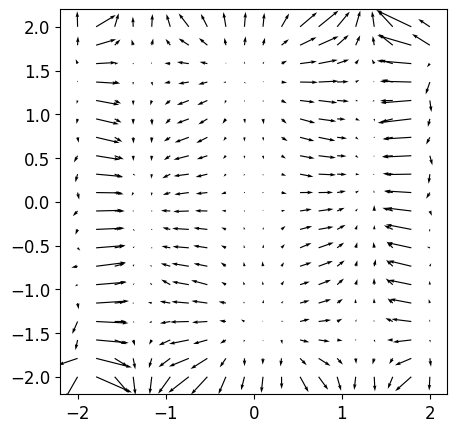

(array([295.,  63.,   5.,   8.,   7.,   9.,   2.,   4.,   4.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([0.02269007, 0.42733297, 0.83197586, 1.23661876, 1.64126165,
        2.04590455, 2.45054745, 2.85519034, 3.25983324, 3.66447613,
        4.06911903, 4.47376193, 4.87840482, 5.28304772, 5.68769061,
        6.09233351, 6.49697641, 6.9016193 , 7.3062622 , 7.71090509,
        8.11554799]),
 <BarContainer object of 20 artists>)

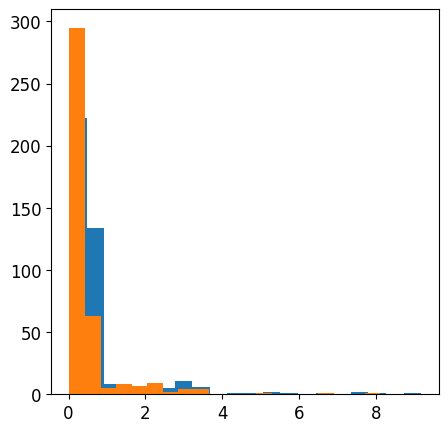

In [13]:
# plt.contour(X, Y, Z, levels=10)

curr_Z_f1 = np.array(res["ours"][0.125]).reshape(num_y_f1, num_x_f1, 2)
print("total err", jnp.linalg.norm(curr_Z_f1 - Zf1))

# plt.quiver(Xf1, Yf1, Zf1[:, :, 0], Zf1[:, :, 1], color="blue")
plt.quiver(Xf1, Yf1, curr_Z_f1[:, :, 0], curr_Z_f1[:, :, 1])

plt.show()

hist_vals2 = np.linalg.norm((curr_Z_f1 - Zf1).reshape(-1, 2), axis=1)
plt.hist(hist_vals1, bins=20)
plt.hist(hist_vals2, bins=20)

total err 12.964782031740283


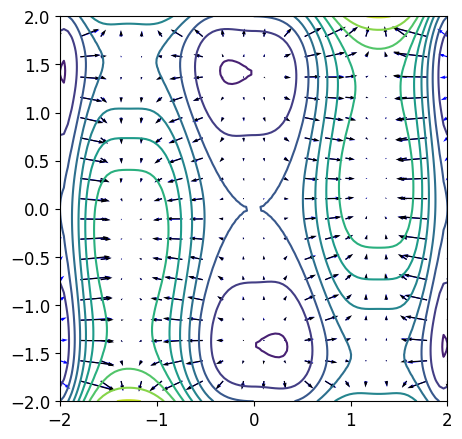

(array([275.,  77.,  14.,   3.,   0.,   2.,   4.,   2.,   1.,   4.,   0.,
          3.,   2.,   2.,   1.,   3.,   2.,   3.,   0.,   2.]),
 array([0.01213565, 0.18698646, 0.36183728, 0.53668809, 0.71153891,
        0.88638972, 1.06124054, 1.23609135, 1.41094216, 1.58579298,
        1.76064379, 1.93549461, 2.11034542, 2.28519624, 2.46004705,
        2.63489787, 2.80974868, 2.98459949, 3.15945031, 3.33430112,
        3.50915194]),
 <BarContainer object of 20 artists>)

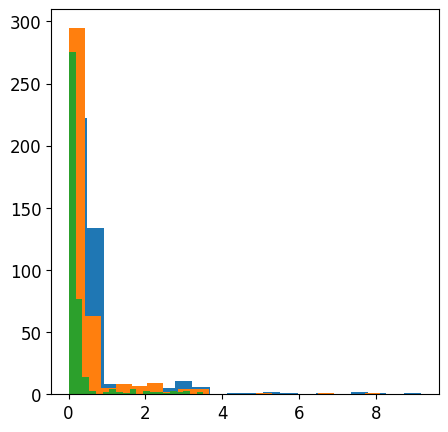

In [14]:
plt.contour(X, Y, Z, levels=10)

curr_Z_f1 = np.array(res["CFD"][0.075]).reshape(num_y_f1, num_x_f1, 2)
print("total err", jnp.linalg.norm(curr_Z_f1 - Zf1))

plt.quiver(Xf1, Yf1, Zf1[:, :, 0], Zf1[:, :, 1], color="blue")
plt.quiver(Xf1, Yf1, curr_Z_f1[:, :, 0], curr_Z_f1[:, :, 1])
           
plt.show()

hist_vals3 = np.linalg.norm((curr_Z_f1 - Zf1).reshape(-1, 2), axis=1)
plt.hist(hist_vals1, bins=20)
plt.hist(hist_vals2, bins=20)
plt.hist(hist_vals3, bins=20)